In [62]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [7]:
financial_news = pd.read_csv('aapl_news.csv')

In [8]:
financial_news

,title,url,time_published,authors,summary,source,category_within_source,source_domain,topics,sentiment_score,sentiment_label,ticker
0,"US stocks fall, oil tops $105 as Ukraine crisi...",https://www.aljazeera.com/economy/2022/3/1/us-...,20220301T080000,Rita Nazareth,A surge in oil sent shivers through risky asse...,Al Jareeza,NaN,www.aljazeera.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.277460,Somewhat-Bearish,"AAPL, FOREX:JPY"
1,Apple halts product sales in Russia after Ukra...,https://www.scmp.com/tech/big-tech/article/316...,20220302T020013,Bloomberg,Apple Inc halted sales of the iPhone and its o...,South China Morning Post,Companies,www.scmp.com,"[{'topic': 'Technology', 'relevance_score': '0...",-0.495467,Bearish,"HPQ, NKE, AAPL"
2,Russia says its economy is taking 'serious blo...,https://www.cnn.com/2022/03/02/business/russia...,20220302T080000,"Mark Thompson and Vasco Cotovio, CNN Business",London/Moscow ( CNN Business ) The Russian...,CNN,Markets,www.cnn.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.469431,Bearish,"EADSF, AAPL, TTE, BA, XOM, FOREX:RUB, FOREX:USD"
3,"Rich Russians turn to luxury jewellery, watche...",https://www.aljazeera.com/economy/2022/3/2/ric...,20220302T080000,"Angelina Rascouet and Andy Hoffman, Flavia Rot...",With sanctions on Russia sending the ruble plu...,Al Jareeza,NaN,www.aljazeera.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.118323,Neutral,"AAPL, MS, XOM, NKE, BBRYF, BP, PPRUF, RYDAF, F..."
4,"Market Rallies, But Still Must Do This; 5 Stoc...",https://www.investors.com/market-trend/stock-m...,20220303T080000,"Investor's Business Daily, ED CARSON",Dow Jones Futures: Stock Market Rallies On 'Ni...,Investors Business Daily,NaN,www.investors.com,"[{'topic': 'Life Sciences', 'relevance_score':...",-0.092622,Neutral,"AAPL, AVGO, SNOW, DDOG, MU, OKE, RMBS, MOS, TS..."
...,...,...,...,...,...,...,...,...,...,...,...,...
26531,"The Best Warren Buffett Stocks to Buy With $2,...",https://www.fool.com/investing/2025/03/22/the-...,20250322T201300,Chris Neiger,The S&P 500 is down more than 7% over the past...,Motley Fool,NaN,www.fool.com,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.228025,Somewhat-Bullish,"MSFT, AXP, AAPL, GS, AMZN, BRK-A"
26532,2 Millionaire-Maker Technology Stocks to Buy,https://www.fool.com/investing/2025/03/23/2-mi...,20250323T091500,Geoffrey Seiler,When it comes to looking for millionaire-makin...,Motley Fool,NaN,www.fool.com,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.298330,Somewhat-Bullish,"MSFT, NVDA, AAPL, SOUN, RMHI, AWON, AMZN"
26533,"Apple's Siri AI Crisis, Security Flaws, And Ch...",https://www.benzinga.com/25/03/44449789/apples...,20250323T110119,Rounak Jain,The past week has been a rollercoaster for App...,Benzinga,News,www.benzinga.com,"[{'topic': 'Technology', 'relevance_score': '1...",-0.105048,Neutral,AAPL
26534,"Google's AI Sprint, OpenAI Legal Drama, Nvidia...",https://www.benzinga.com/25/03/44450126/google...,20250323T132018,Rounak Jain,The past week has been a rollercoaster ride in...,Benzinga,News,www.benzinga.com,"[{'topic': 'Technology', 'relevance_score': '0...",0.108205,Neutral,"GOOG, NVDA, AAPL, GM"


In [9]:
financial_news.dtypes

title                      object
url                        object
time_published             object
authors                    object
summary                    object
source                     object
category_within_source     object
source_domain              object
topics                     object
sentiment_score           float64
sentiment_label            object
ticker                     object
dtype: object

In [10]:
financial_news['Date'] = pd.to_datetime(financial_news['time_published'])
financial_news['Date']

0       2022-03-01 08:00:00
1       2022-03-02 02:00:13
2       2022-03-02 08:00:00
3       2022-03-02 08:00:00
4       2022-03-03 08:00:00
                ...        
26531   2025-03-22 20:13:00
26532   2025-03-23 09:15:00
26533   2025-03-23 11:01:19
26534   2025-03-23 13:20:18
26535   2025-03-23 15:49:16
Name: Date, Length: 26536, dtype: datetime64[ns]

In [11]:
# Creating a new dataframe column in which story title and story excerpts are merged into one column
financial_news['Merged_Text'] = financial_news['summary']

In [12]:
financial_news.Merged_Text.str.strip()

0        A surge in oil sent shivers through risky asse...
1        Apple Inc halted sales of the iPhone and its o...
2        London/Moscow  (  CNN Business  )  The Russian...
3        With sanctions on Russia sending the ruble plu...
4        Dow Jones Futures: Stock Market Rallies On 'Ni...
                               ...                        
26531    The S&P 500 is down more than 7% over the past...
26532    When it comes to looking for millionaire-makin...
26533    The past week has been a rollercoaster for App...
26534    The past week has been a rollercoaster ride in...
26535    Visual Intelligence feature leaps from iPhone ...
Name: Merged_Text, Length: 26536, dtype: object

In [13]:
# We first need to convert text columns into python lists before passing it onto Tokenizer
merged_list = financial_news['Merged_Text'].values.tolist()

In [14]:
merged_list = [str(item) for item in merged_list]

In [15]:
# Convert merged_list to a list of strings
texts = [str(x) for x in merged_list]

In [16]:
all_positive = []
all_negative = []
all_neutral = []

batch_size = 16

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        all_positive.extend(predictions[:, 0].tolist())
        all_negative.extend(predictions[:, 1].tolist())
        all_neutral.extend(predictions[:, 2].tolist())

In [17]:
table = {
    'News_Text': merged_list,
    'Positive_Sentiment': all_positive,
    'Negative_Sentiment': all_negative,
    'Neutral_Sentiment': all_neutral
}

sentiment_df = pd.DataFrame(table)
sentiment_df['Date'] = financial_news['Date']

In [18]:
sentiment_df

,News_Text,Positive_Sentiment,Negative_Sentiment,Neutral_Sentiment,Date
0,A surge in oil sent shivers through risky asse...,0.030585,0.934787,0.034628,2022-03-01 08:00:00
1,Apple Inc halted sales of the iPhone and its o...,0.009574,0.923768,0.066658,2022-03-02 02:00:13
2,London/Moscow ( CNN Business ) The Russian...,0.025432,0.959439,0.015129,2022-03-02 08:00:00
3,With sanctions on Russia sending the ruble plu...,0.045047,0.613403,0.341550,2022-03-02 08:00:00
4,Dow Jones Futures: Stock Market Rallies On 'Ni...,0.102177,0.028719,0.869104,2022-03-03 08:00:00
...,...,...,...,...,...
26531,The S&P 500 is down more than 7% over the past...,0.010401,0.970690,0.018910,2025-03-22 20:13:00
26532,When it comes to looking for millionaire-makin...,0.227473,0.014384,0.758143,2025-03-23 09:15:00
26533,The past week has been a rollercoaster for App...,0.007363,0.975413,0.017224,2025-03-23 11:01:19
26534,The past week has been a rollercoaster ride in...,0.051587,0.039160,0.909252,2025-03-23 13:20:18


In [19]:
# Custom compound sentiment: weighted average
sentiment_df['compound'] = (
    sentiment_df['Positive_Sentiment'] * 1 +
    sentiment_df['Negative_Sentiment'] * -1 +
    sentiment_df['Neutral_Sentiment'] * 0
)


In [55]:
sentiment_df=sentiment_df.drop(['compound_rolling'], axis=1)

In [60]:
# Rename columns
sentiment_df = sentiment_df.rename(columns={
    'News_Text': 'Context',
    'Positive_Sentiment': 'Positive',
    'Negative_Sentiment': 'Negative',
    'Neutral_Sentiment': 'Neutral',
    'compound': 'Compound'
})

# Reorder columns
sentiment_df = sentiment_df[['Date', 'Context', 'Positive', 'Negative', 'Neutral', 'Compound']]

# Preview
sentiment_df.head()


,Date,Context,Positive,Negative,Neutral,Compound
0,2022-03-01 08:00:00,A surge in oil sent shivers through risky asse...,0.030585,0.934787,0.034628,-0.904202
1,2022-03-02 02:00:13,Apple Inc halted sales of the iPhone and its o...,0.009574,0.923768,0.066658,-0.914194
2,2022-03-02 08:00:00,London/Moscow ( CNN Business ) The Russian...,0.025432,0.959439,0.015129,-0.934006
3,2022-03-02 08:00:00,With sanctions on Russia sending the ruble plu...,0.045047,0.613403,0.341550,-0.568356
4,2022-03-03 08:00:00,Dow Jones Futures: Stock Market Rallies On 'Ni...,0.102177,0.028719,0.869104,0.073458


In [61]:
# Save the sentiment dataframe to a CSV file
sentiment_df.to_csv("Finbert_output_AAPL.csv", index=False)

C:\Program Files\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


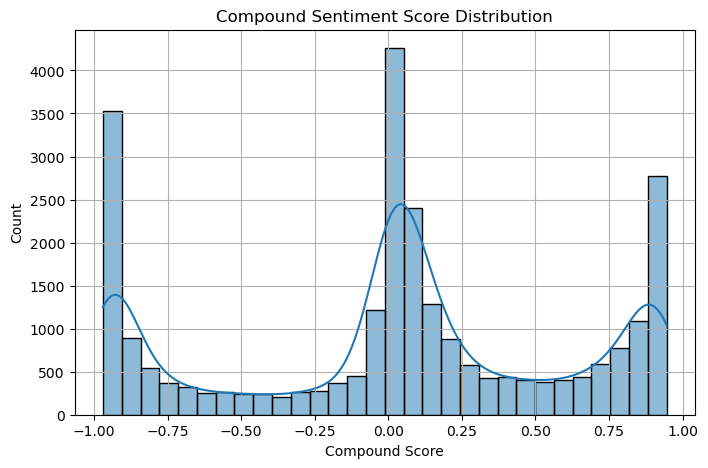

In [64]:
plt.figure(figsize=(8, 5))
sns.histplot(sentiment_df['Compound'], bins=30, kde=True)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Compound Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()